<a href="https://colab.research.google.com/github/daeun118/MachineLearning1/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%ED%8C%80%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_fft_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = np.load("/content/drive/MyDrive/train.npy", allow_pickle=True)
data = data.item()
data_input = data['input']

In [ ]:
labels = data['label']

In [ ]:
data_input

array([[[[-2.8890e+00],
         [-7.9550e+00],
         [-1.6170e+00],
         ...,
         [ 1.9430e+00],
         [-3.0920e+00],
         [-1.7090e+00]],

        [[-3.3770e+00],
         [-8.9310e+00],
         [-1.6170e+00],
         ...,
         [ 2.9200e+00],
         [-3.0920e+00],
         [ 2.4400e-01]],

        [[-3.3770e+00],
         [-8.9310e+00],
         [-1.5300e-01],
         ...,
         [ 3.4080e+00],
         [-3.0920e+00],
         [ 2.1970e+00]],

        ...,

        [[ 5.9000e+00],
         [ 3.7640e+00],
         [-8.9420e+00],
         ...,
         [-1.0000e-02],
         [ 5.2080e+00],
         [-1.9775e+01]],

        [[ 5.4120e+00],
         [ 3.2760e+00],
         [-1.0895e+01],
         ...,
         [-1.0000e-02],
         [ 5.2080e+00],
         [-2.1240e+01]],

        [[ 5.9000e+00],
         [ 2.7870e+00],
         [-1.1383e+01],
         ...,
         [-1.0000e-02],
         [ 5.6970e+00],
         [-2.2217e+01]]],


       [[[-3.8660e+00],


In [ ]:
print(data_input.shape)
print(labels.shape)

(1080, 256, 64, 1)
(1080,)


# 전처리

## data shape 변경

In [ ]:
labels = data['label']
labels.shape
repeated_arr = []
for i in range(len(labels)):
    repeated_arr.extend(np.full(64, labels[i]))

labels_1 = np.array(repeated_arr)
labels_1

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
labels_1.shape

(69120,)

In [ ]:
# (1080, 256, 64, 1)에서 1080 기준으로 반복문 실행
# (256, 64, 1)을 squeeze 하여 (256, 64)로 만든 후 전치 -> (64, 256)
# 결과적으로 (1080, 64, 256) 형태로 변환

input_T = []
for i in range(1080):
    data_input_m = data_input[i][:][:].squeeze().T # data_input_m.shape = (64, 256)
    input_T.append(data_input_m)

input_T = np.array(input_T)
print("input_T.shape:", input_T.shape)

input_T.shape: (1080, 64, 256)


## FFT 적용

### FFT 변환

In [ ]:
def fft(eeg_signal, sampling_rate):
  """
  :param eeg_signal: EEG 신호 (1차원 numpy 배열)
  :param sampling_rate: 샘플링 주파수 (Hz)
  """
  n = len(eeg_signal)
  T = 1 / sampling_rate
  yf = np.fft.fft(eeg_signal) # 추후 IFFT를 위해 abs를 취하지 않은 값을 저장
  xf = np.fft.fftfreq(n, T)
  yf2 = 2.0/n * np.abs(yf[:n//2])

  return xf, yf # 전체 복소수 스펙트럼 반환

In [ ]:
# fft 시각화 함수

def plot_fft(eeg_signal, sampling_rate):
    """
    주어진 EEG 신호에 대한 FFT를 계산하고 주파수 및 해당 주파수 성분의 파워를 시각화합니다.

    :param eeg_signal: EEG 신호 (1차원 numpy 배열)
    :param sampling_rate: 샘플링 주파수 (Hz)
    """
    n = len(eeg_signal)
    T = 1 / sampling_rate
    yf = np.fft.fft(eeg_signal)
    xf = np.fft.fftfreq(n, T)[:n//2]
    yf2 = 2.0/n * np.abs(yf[:n//2])

    plt.plot(xf, yf2)
    plt.title('FFT of EEG Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.grid()
    plt.show()

    return yf2

In [ ]:
# fft변환 시각화

for i in range(808,812):
  for j in range(64):
    print("instance", i+1, "// channel", j+1)
    plot_fft(input_T[i][j], 256)

### 주파수 대역 필터링

In [ ]:
# 주파수 대역 필터링 함수 정의

def frequency_band_filter(yf, xf, low_freq, high_freq):
    filtered_yf = np.zeros_like(yf)
    mask = (xf >= low_freq) & (xf <= high_freq)
    filtered_yf[mask] = yf[mask]  # 필터링 범위 내 데이터만 유지
    return filtered_yf

### 푸리에 역변환(시간 영역으로 변환)

In [ ]:
low_freq = 0  # 최소 주파수
high_freq = 50 # 최대 주파수

filtered_time_domain_data = np.zeros_like(input_T)

for i in range(1080):
    for s in range(64):
        # FFT 수행
        xf, yf = fft(input_T[i][s], 256)

        # 주파수 대역 필터링 적용
        filtered_result = frequency_band_filter(yf, xf, low_freq, high_freq)

        # 역 푸리에 변환을 통해 시간 영역으로 변환
        time_domain_data = np.fft.ifft(filtered_result).real

        # Store in the same structure
        filtered_time_domain_data[i, s] = time_domain_data

filtered_time_domain_data = np.array(filtered_time_domain_data)

In [ ]:
filtered_time_domain_data.shape

(1080, 64, 256)

In [ ]:
# reshape

input_data_0 = filtered_time_domain_data.reshape(1080*64,256)
input_data_0.shape

(69120, 256)

### test data load 및 푸리에 변환

In [ ]:
# test data 로드
data_test=np.load('/content/drive/MyDrive/test.npy', allow_pickle='TRUE')
data_test = data_test.item()
data_input_test = data_test['input']

In [ ]:
input_test_T = []
for i in range(120):
    data_input_m = data_input_test[i][:][:].squeeze().T
    input_test_T.append(data_input_m)

input_test_T = np.array(input_test_T)
input_test_T.shape

(120, 64, 256)

In [ ]:
# fft변환 시각화

for i in range(5):
  for j in range(64):
    print("instance", i, "// channel", j)
    plot_fft(input_test_T[i][j], 256)

In [ ]:
low_freq = 3  # 최소 주파수
high_freq = 50 # 최대 주파수

# 평균 제거 예시
input_test_T_dc_removed = input_test_T - np.mean(input_test_T, axis=-1, keepdims=True)

filtered_time_domain_data_test = np.zeros_like(input_test_T)
for i in range(120):
    for s in range(64):
        # FFT 수행
        xf_test, yf_test = fft(input_test_T_dc_removed[i][s], 256)

        # 주파수 대역 필터링 적용
        filtered_result_test = frequency_band_filter(yf_test, xf_test, low_freq, high_freq)

        # 역 푸리에 변환을 통해 시간 영역으로 변환
        time_domain_data_test = np.fft.ifft(filtered_result_test).real

        filtered_time_domain_data_test[i, s] = time_domain_data_test

filtered_time_domain_data_test = np.array(filtered_time_domain_data_test)

In [ ]:
filtered_time_domain_data_test.shape

(120, 64, 256)

In [ ]:
# reshape

input_data_0_test = filtered_time_domain_data_test.reshape(120*64,256)
input_data_0_test.shape

(7680, 256)

# model

## data split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(input_data_0, labels_1, test_size=0.2, shuffle=True, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(55296, 256) (55296,)
(13824, 256) (13824,)


## 스케일링

In [ ]:
# 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(input_data_0_test)

print(scaled_X_train.shape, y_train.shape)
print(scaled_X_val.shape, y_val.shape)
print(scaled_X_test.shape)

(55296, 256) (55296,)
(13824, 256) (13824,)
(7680, 256)


## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50) # pca 모델 생성
pca.fit(scaled_X_train) # pca 모델 학습

X_train_pca = pca.transform(scaled_X_train)
X_val_pca = pca.transform(scaled_X_val)
X_test_pca = pca.transform(scaled_X_test)

explained_variance_ratio = pca.explained_variance_ratio_
print("설명 분산 비율:", explained_variance_ratio)
print("누적 설명 분산 비율:", sum(explained_variance_ratio))
# 누적 설명 분산 비율이 95% 이상이 되게 n_components 설정

설명 분산 비율: [7.33268791e-01 4.51247497e-02 2.69168097e-02 1.91603820e-02
 1.41251155e-02 1.28820674e-02 1.21331520e-02 1.07504226e-02
 9.87879484e-03 8.89317762e-03 8.38790483e-03 7.42257220e-03
 6.53492912e-03 6.19602624e-03 4.98072521e-03 4.51778309e-03
 3.91485927e-03 3.51653704e-03 3.18581924e-03 3.08421935e-03
 2.96656060e-03 2.79425576e-03 2.60887986e-03 2.45978338e-03
 2.29633058e-03 2.19480347e-03 2.13679151e-03 1.92156639e-03
 1.65795908e-03 1.48996139e-03 1.40865372e-03 1.23028574e-03
 1.16677334e-03 1.09268618e-03 9.96664978e-04 9.74282491e-04
 9.38069167e-04 8.94439914e-04 8.89036914e-04 8.15128024e-04
 7.73033358e-04 7.45540028e-04 7.31260433e-04 7.17238976e-04
 6.97612292e-04 6.79713650e-04 6.69820100e-04 6.40184533e-04
 6.13519908e-04 5.97527090e-04]
누적 설명 분산 비율: 0.9846732009482776


## XGB

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

XG_model = XGBClassifier(n_estimators=300, max_depth=8, learning_rate=0.05,
                         subsample=0.8, colsample_bytree=0.5, gamma=2, reg_lambda=2,
                         reg_alpha=1, min_child_weight=10, random_state=0)

XG_model.fit(scaled_X_train, y_train)

y_pred_xg = XG_model.predict(scaled_X_val)
y_train_xg_hat = XG_model.predict(scaled_X_train)

val_accuracy_xg = accuracy_score(y_val, y_pred_xg)
train_accuracy_xg = accuracy_score(y_train, y_train_xg_hat)
print("train 데이터 정확도:", train_accuracy_xg)
print("valid 데이터 정확도:", val_accuracy_xg)


train 데이터 정확도: 0.9540292245370371
valid 데이터 정확도: 0.8598813657407407


In [ ]:
# 교차검증
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(XG_model, scaled_X_train, y_train, cv=5)

print("교차 검증 정확도:", cv_scores)
print("평균 교차 검증 정확도:", cv_scores.mean())

교차 검증 정확도: [0.84575045 0.85414594 0.84935347 0.84501311 0.84772583]
평균 교차 검증 정확도: 0.8483977619956221


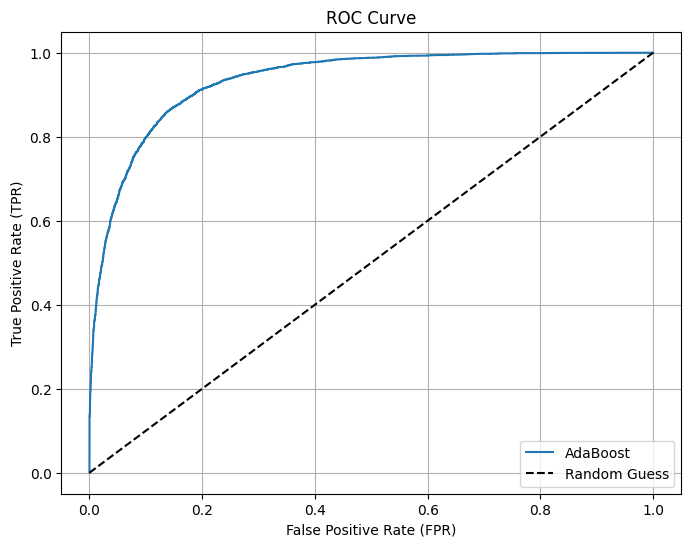

In [ ]:
# ROC 커브

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 검증 데이터에 대한 예측 확률 얻기
y_proba_xg = XG_model.predict_proba(scaled_X_val)[:, 1]  # 양성 클래스에 대한 예측 확률

# ROC 커브 생성
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_val, y_proba_xg)

# ROC 커브 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr_xg, tpr_xg, label='AdaBoost')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Precision과 Recall 계산
precision = precision_score(y_val, y_pred_xg)
recall = recall_score(y_val, y_pred_xg)

print("Precision:", precision)
print("Recall:", recall)


Precision: 0.8462596259625963
Recall: 0.8825469668722215


## 민감도, 특이도, 혼동행렬

In [ ]:
from sklearn.metrics import confusion_matrix

# 검증 데이터에 대한 예측
y_pred_xg = XG_model.predict(scaled_X_val)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_val, y_pred_xg)

# 민감도와 특이도 계산
TP = conf_matrix[1, 1]  # True Positive
FN = conf_matrix[1, 0]  # False Negative
FP = conf_matrix[0, 1]  # False Positive
TN = conf_matrix[0, 0]  # True Negative

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensitivity (민감도):", sensitivity)
print("Specificity (특이도):", specificity)
print("Confusion Matrix:\n", conf_matrix)

Sensitivity (민감도): 0.8825469668722215
Specificity (특이도): 0.8368121442125237
Confusion Matrix:
 [[5733 1118]
 [ 819 6154]]


## 제출용

In [ ]:
# 제출용
# X_test_pca

y_test_pred_xg = XG_model.predict(scaled_X_test)
XG_model.predict_proba(scaled_X_test)

print(y_test_pred_xg.mean())

0.5651041666666666


## 예측값 형태 변경

In [ ]:
y_test_pred_xg.shape
# 확장시켜놓은 형태이므로 다시 원래대로 돌려야 함.

(7680,)

In [ ]:
y_test_pred_xg

array([0, 1, 1, ..., 1, 0, 0])

In [ ]:
answer = []

for i in range(120):
    pred = []
    for s in range(64):
        pred.append(y_test_pred_xg[i*64+s])
    if sum(pred)/len(pred) > 0.56: # 64개씩 그룹지어서 다수결 방식. 임계값 지정
        answer.append(1)
    else:
        answer.append(0)

len(answer)

120

In [ ]:
sum(answer)/len(answer)

0.5083333333333333

In [ ]:
# 제출하기
id=np.arange(120)
target=answer

submission_df=pd.DataFrame({'ID':id, 'Target':target})

submission_df

,ID,Target
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1
...,...,...
115,115,1
116,116,1
117,117,0
118,118,0


In [ ]:
submission_df.to_csv('submission05034.csv', index=False)